In [1]:
import numpy as np
import pandas as pd
import json
import re
import nltk
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
stop_words = list(stopwords.words('english')) + ['bitcoin', 'btc']

In [2]:
bitcoin_tweets_df = pd.read_csv('Data/tweets/bitcoin_tweets_cleaned_sent.csv', encoding='ascii', parse_dates=True)

c:\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
bitcoin_tweets_df.head()

date                                               text  \
0  2021-02-05 10:52:04   debunking bitcoin myths by patrick lowry cryp...   
1  2021-02-05 10:52:04   weekend read keen to learn about crypto asset...   
2  2021-02-05 10:52:06   bloomberg lp cryptooutlook with mikemcglone c...   
3  2021-02-05 10:52:07   blockchain by delrayman forbes forbescrypto c...   
4  2021-02-05 10:52:26   reddcoin rdd reddcoin to the moon altcoin tur...   

  is_retweet  subjectivity  polarity sentiment  vader_compound  vader_pos  \
0      False           0.0       0.0   neutral          0.0000      0.000   
1      False           0.0       0.0   neutral          0.4939      0.244   
2      False           0.0       0.0   neutral          0.0000      0.000   
3      False           0.0       0.0   neutral          0.0000      0.000   
4      False           0.0       0.0   neutral          0.0000      0.000   

   vader_neg  vader_neu  afinn_score  
0        0.0      1.000          0.0  
1        0.0      0.756          3.0  
2        0.0      1.000          0.0  
3        0.0      1.000          0.0  
4        0.0      1.000          0.0

In [4]:
bitcoin_tweets_df.text=bitcoin_tweets_df.text.str.lower()

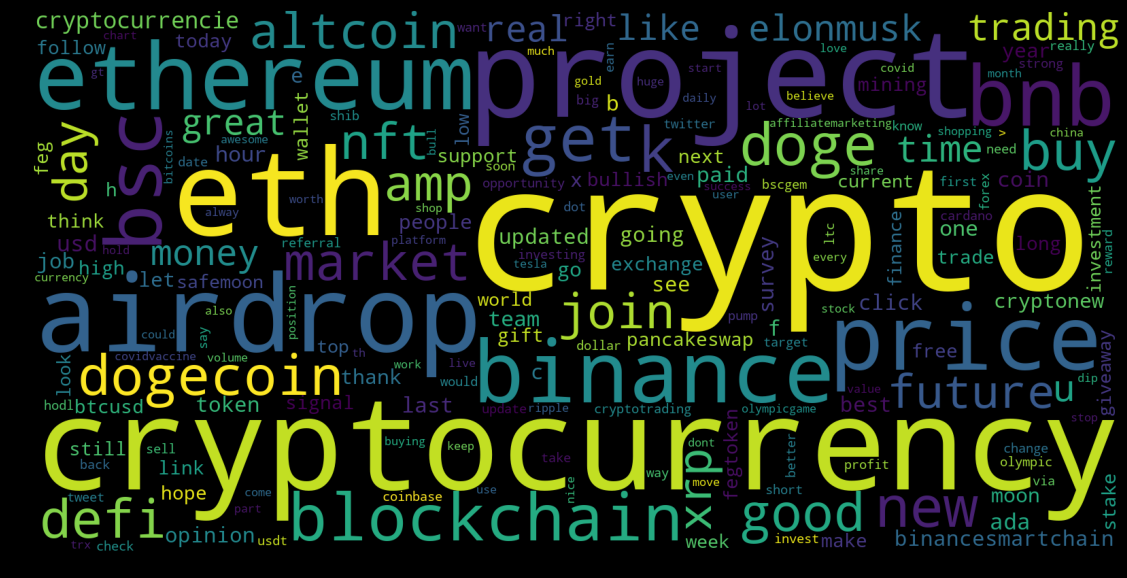

In [5]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['subjectivity']>=0,:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

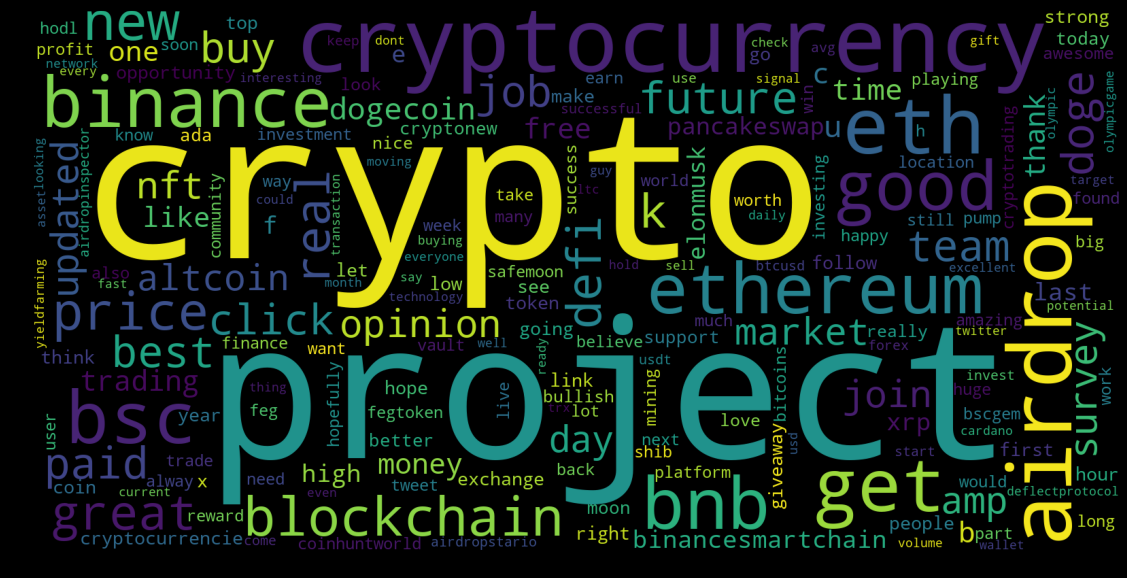

In [6]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['sentiment']=='positive',:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

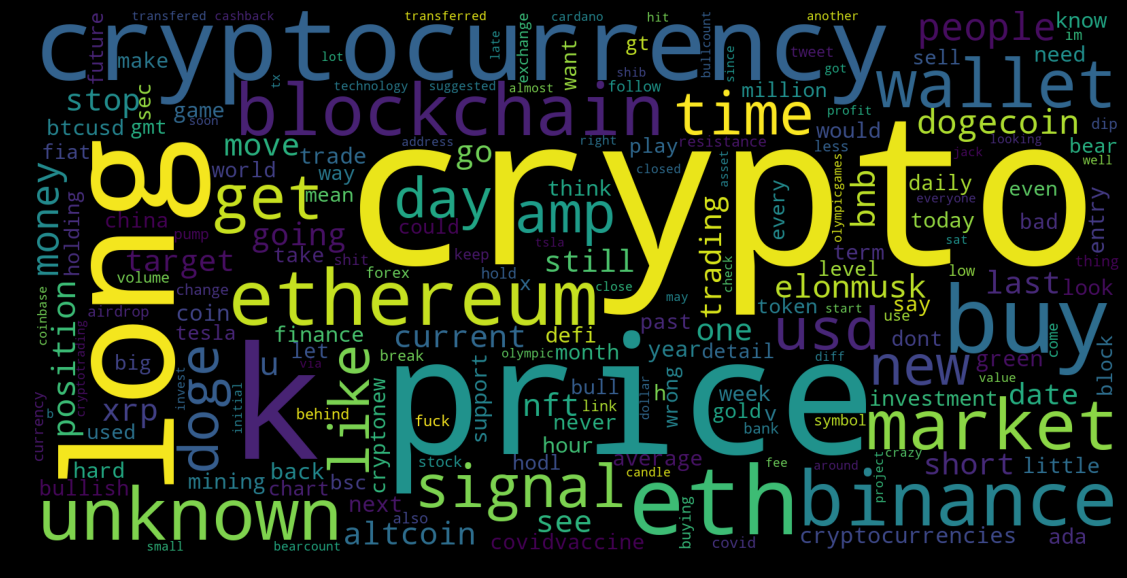

In [7]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['sentiment']=='negative',:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

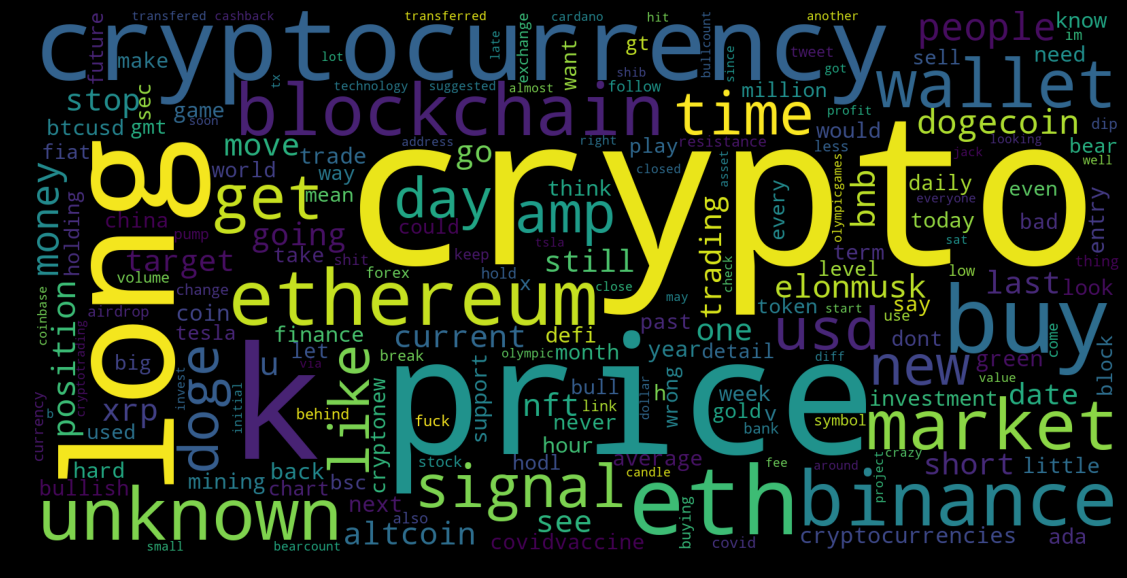

In [8]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['sentiment']=='negative',:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

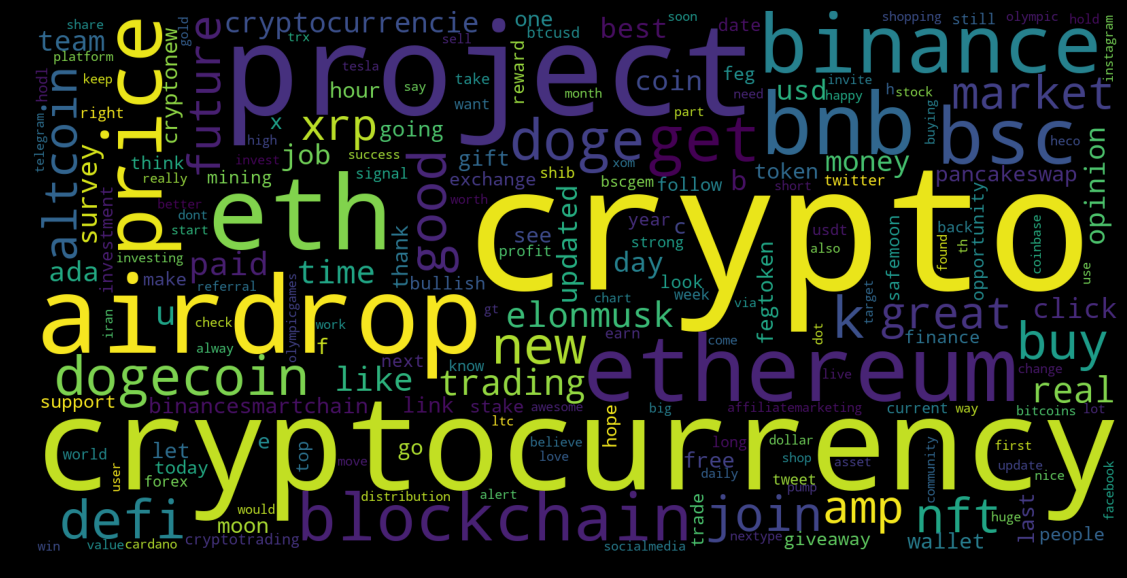

In [9]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['vader_compound']>=0,:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

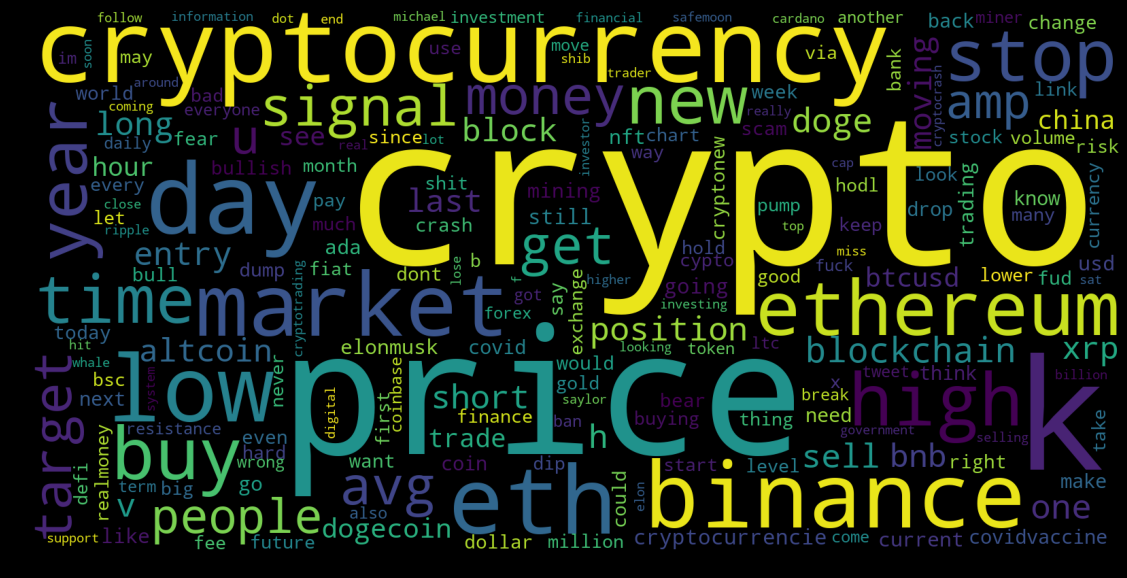

In [10]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['vader_compound']<0,:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

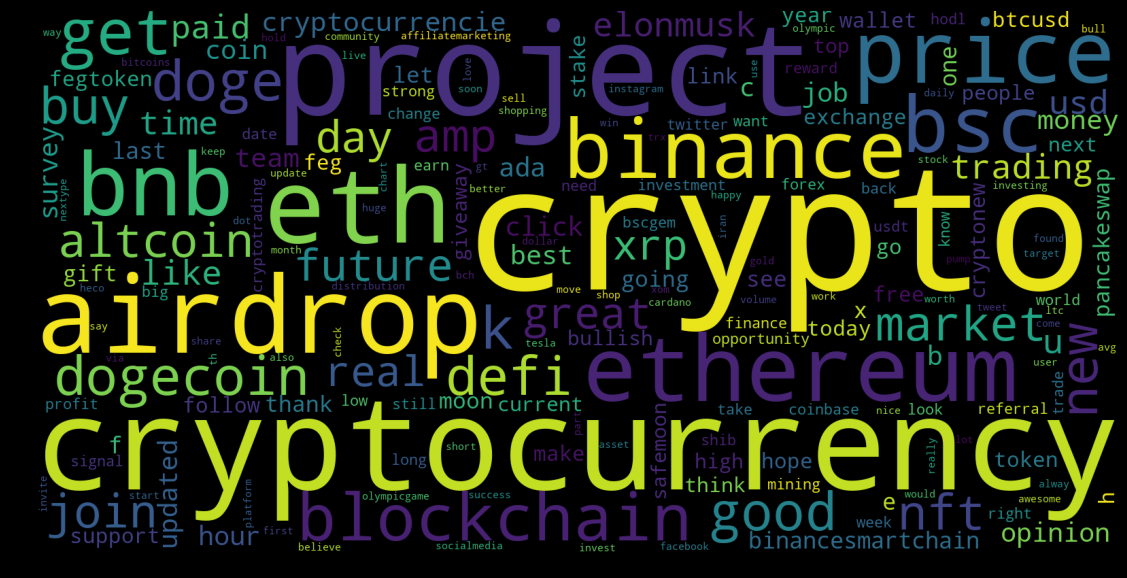

In [11]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['afinn_score']>=0,:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

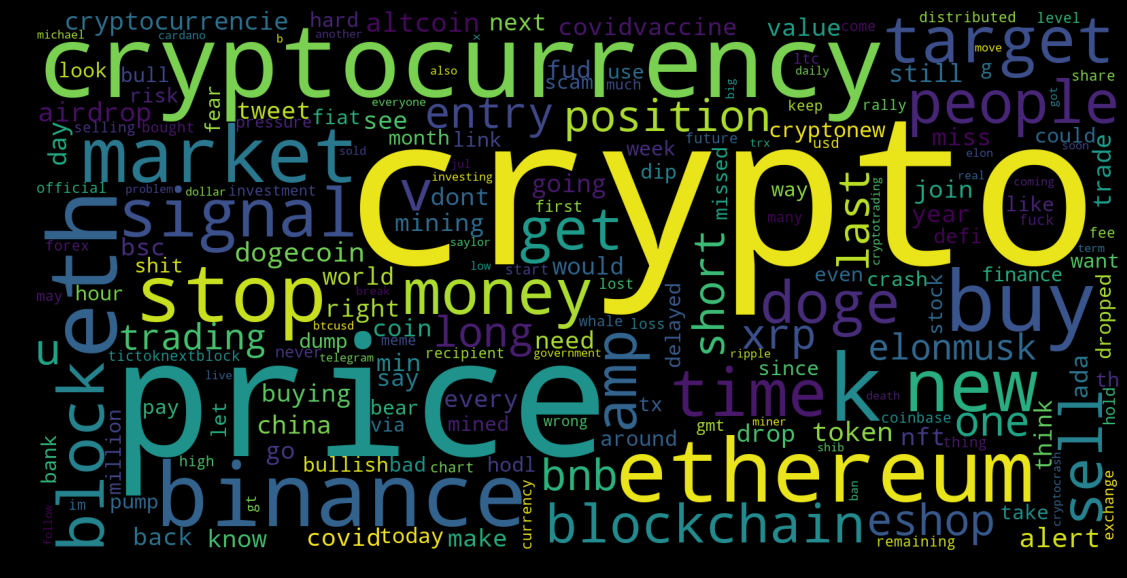

In [12]:
wordcloud=WordCloud(background_color="black",width=1600, height=800, 
                    random_state=0, 
                    collocations=False, stopwords=stop_words).generate(' '.join(bitcoin_tweets_df.loc[bitcoin_tweets_df['afinn_score']<0,:]['text'].tolist()))

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

In [14]:
class TweetPreprocessor:
    
    """
    Input:
        Downloaded tweets from the Twitter API
    
    Attributes:
        df : dataframe
            A dataframe containing the collected tweets
    
    Output:
        A cleaned dataframe with the collected tweets
        
    """
    
    # Instantiate the WordNetLemmatizer as a class attribute
    lemmatizer = WordNetLemmatizer()   
    
    def __init__(self, df):
        self.df = df
    
    def __remove_whitespaces(self):
        """ Replaces any part of the tweet containing duplicate whitespaces with a single space """
        self.df['text'] = self.df['text'].map(lambda x: re.sub('\s+', ' ', str(x)).strip())

    def __filter_alphabetic(self):
        """ Removes emojis, etc. by first encoding and then decoding the tweet as ascii """
        self.df['text'] = self.df['text'].map(lambda x: x.encode('ascii', 'ignore').decode('ascii', 'ignore'))
    
    def __lowercase(self):
        """ Change all characters in the tweet to lowercase """
        self.df['text'] = self.df['text'].map(lambda x: x.lower() if isinstance(x, str) else x)
        
    def __lemmatize(self):
        """ 
        Transform the tweet to group together different inflected types of words by mapping their
        POS tag (part of speech) to one of four word classes and then applying the lemmatizer
        """
        def get_wordnet_pos(word):
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        
        self.df['lemmatized_text'] = self.df['text'].apply(
            lambda x: ' '.join(self.lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)))
        
        return self.df
    
    def preprocess_data(self):
        self.__remove_whitespaces()
        self.__filter_alphabetic()
        self.__lowercase()
        self.__lemmatize()
        
        return self.df

In [16]:
tp = TweetPreprocessor(bitcoin_tweets_df)

In [ ]:
bitcoin_tweets_df = tp.preprocess_data()

In [ ]:
vect = CountVectorizer(stop_words='english', token_pattern='(?u)\\b\\w\\w\\w+\\b')
words = vect.fit_transform(bitcoin_tweets_df['text'])

In [ ]:
search_string = ['bitcoin', 'btc']

In [ ]:
def plot_sentiment(df):
    """ 
    Plot sentiment analysis.
    """
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    bins = np.linspace(-1, 1, 21)
    ax = sns.distplot(df['vade_compound'], bins=bins)
    ax.set_xlabel('Vader Sentiment \n Search string: {}'.format(search_string), fontsize='large')
    ax.set_ylabel('Density', fontsize='large')
    ax.set_title('Vader Sentiment analysis distribution', fontsize='x-large', fontweight='bold')
    
def plot_wordfreq(df):
    """ 
    Plot word frequencies.
    """
    words_sum = words.sum(axis=0)
    words_freq = [(word, words_sum[0, i]) for word, i in vect.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    freq = pd.DataFrame(words_freq, columns=['word', 'freq'])

    fig = plt.figure(figsize=(12,6))
    ax = sns.barplot(freq['word'].head(20), freq['freq'].head(20), palette='Blues_r')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Word', fontsize='large')
    ax.set_ylabel('Frequency', fontsize='large')
    ax.set_title('Word frequency', fontsize='x-large', fontweight='bold')
    
def plot_wordcloud(df):
    """ 
    Plot word cloud.
    """
    text_concat = ' '.join([text for text in df['text']])
    wordcloud = WordCloud(background_color="white", width=1400, height=800).generate(text_concat)
    
    fig = plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.title('Wordcloud', fontsize='x-large', fontweight='bold')
    plt.axis("off")
    plt.tight_layout(pad=0)

In [ ]:
plot_sentiment(bitcoin_tweets_df)
plot_wordfreq(bitcoin_tweets_df)
plot_wordcloud(bitcoin_tweets_df)